Training model on the L1 dataset.

In [2]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data loading

In [3]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_L1.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_L.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_L.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


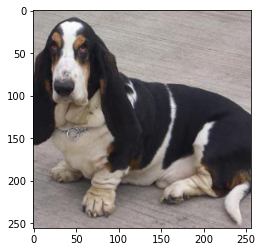

In [4]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model (6 conv layers)

In [6]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)

learning_rate = 0.001
decay_rate = 0.0005
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128,

Epoch:8
Iteration:1400
Time taken for the last 50 iterations: 35.15483832359314
Current training loss:2.9091408252716064
Current training accuracy:0.21728515625
Current validation loss:2.9588727951049805
Current validation accuracy:0.16648530960083008
Epoch:8
Iteration:1450
Time taken for the last 50 iterations: 35.48652529716492
Current training loss:2.9743106365203857
Current training accuracy:0.193359375
Current validation loss:2.990539312362671
Current validation accuracy:0.15886832773685455
Epoch:8
Iteration:1500
Time taken for the last 50 iterations: 35.08460283279419
Current training loss:2.897648572921753
Current training accuracy:0.20556640625
Current validation loss:2.9881210327148438
Current validation accuracy:0.17627856135368347
Epoch:8
Iteration:1550
Time taken for the last 50 iterations: 35.45914316177368
Current training loss:2.9113080501556396
Current training accuracy:0.2080078125
Current validation loss:2.9839863777160645
Current validation accuracy:0.166485309600830

Epoch:17
Iteration:3050
Time taken for the last 50 iterations: 35.53252363204956
Current training loss:2.34602427482605
Current training accuracy:0.3583984375
Current validation loss:2.5169789791107178
Current validation accuracy:0.28291621804237366
Epoch:17
Iteration:3100
Time taken for the last 50 iterations: 35.19081139564514
Current training loss:2.3274965286254883
Current training accuracy:0.36328125
Current validation loss:2.5391597747802734
Current validation accuracy:0.2916213274002075
Epoch:18
Iteration:3150
Time taken for the last 50 iterations: 35.454837799072266
Current training loss:2.385582447052002
Current training accuracy:0.34765625
Current validation loss:2.5621230602264404
Current validation accuracy:0.26877039670944214
Epoch:18
Iteration:3200
Time taken for the last 50 iterations: 35.63589310646057
Current training loss:2.3234548568725586
Current training accuracy:0.37548828125
Current validation loss:2.518857002258301
Current validation accuracy:0.277475506067276
E

Epoch:27
Iteration:4700
Time taken for the last 50 iterations: 35.53678750991821
Current training loss:2.058717727661133
Current training accuracy:0.43896484375
Current validation loss:2.3569962978363037
Current validation accuracy:0.31882479786872864
Epoch:27
Iteration:4750
Time taken for the last 50 iterations: 35.594276666641235
Current training loss:2.0286238193511963
Current training accuracy:0.45556640625
Current validation loss:2.30839467048645
Current validation accuracy:0.3351469039916992
Epoch:27
Iteration:4800
Time taken for the last 50 iterations: 35.44010877609253
Current training loss:2.049741506576538
Current training accuracy:0.4423828125
Current validation loss:2.3768646717071533
Current validation accuracy:0.31664854288101196
Epoch:27
Iteration:4850
Time taken for the last 50 iterations: 35.572258949279785
Current training loss:2.0242843627929688
Current training accuracy:0.45068359375
Current validation loss:2.319222927093506
Current validation accuracy:0.32535365223

Epoch:36
Iteration:6350
Time taken for the last 50 iterations: 35.62199902534485
Current training loss:1.8672728538513184
Current training accuracy:0.48388671875
Current validation loss:2.2809746265411377
Current validation accuracy:0.341675728559494
Epoch:36
Iteration:6400
Time taken for the last 50 iterations: 35.69784188270569
Current training loss:1.85181725025177
Current training accuracy:0.4912109375
Current validation loss:2.2313809394836426
Current validation accuracy:0.3514689803123474
Epoch:37
Iteration:6450
Time taken for the last 50 iterations: 35.504969120025635
Current training loss:1.7529664039611816
Current training accuracy:0.5625
Current validation loss:2.1771178245544434
Current validation accuracy:0.36996734142303467
Epoch:37
Iteration:6500
Time taken for the last 50 iterations: 35.65214729309082
Current training loss:1.7766650915145874
Current training accuracy:0.52197265625
Current validation loss:2.2381277084350586
Current validation accuracy:0.3471164405345917
E

Current validation loss:2.166332960128784
Current validation accuracy:0.3971708416938782
Epoch:45
Iteration:8000
Time taken for the last 50 iterations: 37.39620232582092
Current training loss:1.5824470520019531
Current training accuracy:0.5859375
Current validation loss:2.1342825889587402
Current validation accuracy:0.38302502036094666
Epoch:46
Iteration:8050
Time taken for the last 50 iterations: 40.335108280181885
Current training loss:1.698205590248108
Current training accuracy:0.58203125
Current validation loss:2.218214988708496
Current validation accuracy:0.3819368779659271
Epoch:46
Iteration:8100
Time taken for the last 50 iterations: 38.54881691932678
Current training loss:1.6118848323822021
Current training accuracy:0.59814453125
Current validation loss:2.11842942237854
Current validation accuracy:0.3884657323360443
Epoch:46
Iteration:8150
Time taken for the last 50 iterations: 36.6853141784668
Current training loss:1.607553243637085
Current training accuracy:0.59375
Current va

Current validation loss:2.1206767559051514
Current validation accuracy:0.3786724805831909
Epoch:55
Iteration:9650
Time taken for the last 50 iterations: 34.57942008972168
Current training loss:1.4624603986740112
Current training accuracy:0.6318359375
Current validation loss:2.1227943897247314
Current validation accuracy:0.367791086435318
Epoch:55
Iteration:9700
Time taken for the last 50 iterations: 35.757161378860474
Current training loss:1.507802963256836
Current training accuracy:0.6357421875
Current validation loss:2.153973340988159
Current validation accuracy:0.36670294404029846
Epoch:56
Iteration:9750
Time taken for the last 50 iterations: 39.09588098526001
Current training loss:1.5297845602035522
Current training accuracy:0.62255859375
Current validation loss:2.1331334114074707
Current validation accuracy:0.3645266592502594
Epoch:56
Iteration:9800
Time taken for the last 50 iterations: 38.75572609901428
Current training loss:1.465348482131958
Current training accuracy:0.67285156

Current training loss:1.4419312477111816
Current training accuracy:0.6552734375
Current validation loss:2.1429264545440674
Current validation accuracy:0.3754080533981323
Epoch:64
Iteration:11300
Time taken for the last 50 iterations: 35.40854263305664
Current training loss:1.3479220867156982
Current training accuracy:0.68310546875
Current validation loss:2.0815205574035645
Current validation accuracy:0.3939064145088196
Epoch:65
Iteration:11350
Time taken for the last 50 iterations: 36.68388080596924
Current training loss:1.4135481119155884
Current training accuracy:0.6728515625
Current validation loss:2.096329689025879
Current validation accuracy:0.3841131627559662
Epoch:65
Iteration:11400
Time taken for the last 50 iterations: 34.47642183303833
Current training loss:1.3891123533248901
Current training accuracy:0.66455078125
Current validation loss:2.112408399581909
Current validation accuracy:0.3775843381881714
Epoch:65
Iteration:11450
Time taken for the last 50 iterations: 34.5862541

Epoch:74
Iteration:12900
Time taken for the last 50 iterations: 36.52846837043762
Current training loss:1.3037163019180298
Current training accuracy:0.703125
Current validation loss:2.070040225982666
Current validation accuracy:0.38302502036094666
Epoch:74
Iteration:12950
Time taken for the last 50 iterations: 37.186018228530884
Current training loss:1.294566035270691
Current training accuracy:0.71142578125
Current validation loss:2.04599928855896
Current validation accuracy:0.3884657323360443
Epoch:74
Iteration:13000
Time taken for the last 50 iterations: 36.56256628036499
Current training loss:1.326926589012146
Current training accuracy:0.708984375
Current validation loss:2.081181287765503
Current validation accuracy:0.38955387473106384
Epoch:74
Iteration:13050
Time taken for the last 50 iterations: 36.63455772399902
Current training loss:1.2501288652420044
Current training accuracy:0.72314453125
Current validation loss:2.0527660846710205
Current validation accuracy:0.409140378236770

Current validation loss:2.0282044410705566
Current validation accuracy:0.41240477561950684
Epoch:83
Iteration:14550
Time taken for the last 50 iterations: 36.46863532066345
Current training loss:1.189713954925537
Current training accuracy:0.73291015625
Current validation loss:2.069690227508545
Current validation accuracy:0.37214362621307373
Epoch:83
Iteration:14600
Time taken for the last 50 iterations: 36.803030490875244
Current training loss:1.250229001045227
Current training accuracy:0.74853515625
Current validation loss:2.0723378658294678
Current validation accuracy:0.3884657323360443
Epoch:84
Iteration:14650
Time taken for the last 50 iterations: 36.38866949081421
Current training loss:1.178715467453003
Current training accuracy:0.7529296875
Current validation loss:2.0329432487487793
Current validation accuracy:0.3917301297187805
Epoch:84
Iteration:14700
Time taken for the last 50 iterations: 39.38919258117676
Current training loss:1.1473565101623535
Current training accuracy:0.75

KeyboardInterrupt: 

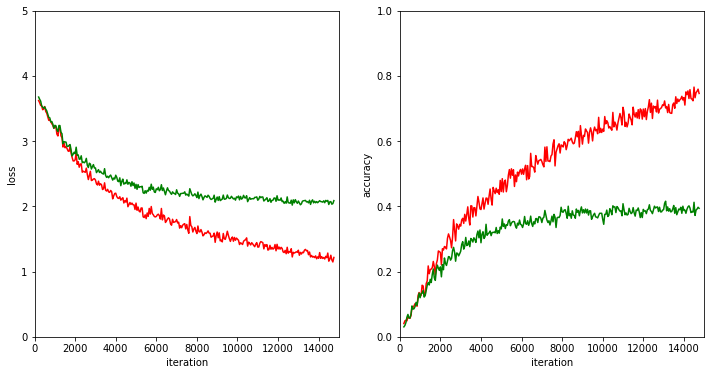

In [7]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,15000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,15000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model (6 conv layers, 2 dense layers)

In [ ]:
class PetCNN6ch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 370))
        
        self.dense2 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = self.dense2(out)
        out = nn.functional.log_softmax(out,dim=1)    
        
        return out
    


model1 = PetCNN6ch()
loss_function = nn.NLLLoss()


print(model1)
        


learning_rate = 0.001
decay_rate = 0.0001
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 150

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 25